In [ ]:
# from zipfile import ZipFile

# file_name = "data.zip"

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

In [ ]:
import os
from collections import Counter
import math
import cv2 as cv
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def euclidean_distance(sample1, sample2):
    sum_squared_distance = 0
    for i in range(len(sample1)):
        sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
    return math.sqrt(sum_squared_distance)

In [ ]:
def knn_classifier(data, train_labels, queries, k):

  data = pd.DataFrame(data=data)
  data[-1] = train_labels
  data = data.to_numpy().tolist()

  predictions = []
  for query in queries:
      neighbor_distances_and_indices = []
      
      for index, example in enumerate(data):
          distance = euclidean_distance(example[:-1], query)
          neighbor_distances_and_indices.append((distance, index))
      
      sorted_neighbor_distances_and_indices = sorted(neighbor_distances_and_indices)        
      k_nearest_distances_and_indices = sorted_neighbor_distances_and_indices[:k]        
      k_nearest_labels = [data[i][-1] for distance, i in k_nearest_distances_and_indices]
      predictions.append(Counter(k_nearest_labels).most_common(1)[0][0])
  
  return predictions

In [ ]:
def accuracy(y_true, y_pred):
    correct = 0
    for true, pred in zip(y_true, y_pred):
        if true == pred:
            correct += 1
    return correct / len(y_true)

In [ ]:
number_of_classes = 40

rootdir = 'data'
images = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        images.append(cv.imread(os.path.join(subdir, file), cv.IMREAD_GRAYSCALE))

images = np.array(images)

In [ ]:
samples = 400
dimensions = 10304

data = np.zeros((samples, dimensions))

i = 0
for image in images:
    data[i] = image.reshape((1, -1))
    i += 1

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [ ]:
# 50 - 50 data separation

training_samples = 200
testing_samples = 200
training_samples_per_class = 5
testing_samples_per_class = 5

# 70 - 30 data separation

# training_samples = 280
# testing_samples = 120
# training_samples_per_class = 7
# testing_samples_per_class = 3

In [ ]:
def train_test_split_even_odd():
  train = [list(data[i]) for i in range(samples) if i % 2 != 0]
  test = [list(data[i]) for i in range(samples) if i % 2 == 0]
  return train, test

In [ ]:
def train_test_split_7_3():
  
  samples_per_class = 10
  
  classes = [data[i:i+samples_per_class].tolist() for i in range(0, samples, samples_per_class)]

  training_data = []
  testing_data = []
  for i in range(number_of_classes):
    for j in range(samples_per_class):
      if j < 7:
        training_data.append(classes[i][j])
      else:
        testing_data.append(classes[i][j])
  return training_data, testing_data

In [ ]:
# 50 - 50 data separation
training_data, testing_data  = train_test_split_even_odd()
X_train, X_test  = train_test_split_even_odd()

# # 70 - 30 data separation
# training_data, testing_data = train_test_split_7_3()
# X_train, X_test = train_test_split_7_3()

In [ ]:
def get_labels(spc):
  labels = []
  for i in range(number_of_classes):
      for j in range(spc):
          labels.append(i+1)
  return labels

train_labels = get_labels(training_samples_per_class)
test_labels = get_labels(testing_samples_per_class)

In [ ]:
def find_n(alpha_s, eig_vals):
  n = []
  eigen_values = eig_vals.tolist()
  summation = sum(eigen_values)
  for i in range(len(alpha_s)):
    temp = alpha_s[i]
    temp *= summation
    n_components = 0
    l = 0
    while l < temp:
      l += eigen_values[n_components]
      n_components += 1
    n.append(n_components)
  return n

In [ ]:
# KERNEL PCA

from sklearn.decomposition import KernelPCA

kpca = KernelPCA(kernel='linear')
X_kpca = kpca.fit_transform(training_data)
X_kpca_test = kpca.transform(testing_data)

score = []
classified_labels = []
for k in [1, 3, 5, 7]:
  current_classified_labels = knn_classifier(X_kpca, train_labels, X_kpca_test, k)
  classified_labels.append(current_classified_labels)
  score.append(accuracy(test_labels, current_classified_labels))
score

[0.945, 0.9, 0.86, 0.79]

In [ ]:
# KERNEL LCA

from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

kpca = KernelPCA(kernel='linear')
X_kpca = kpca.fit_transform(training_data)
X_kpca_test = kpca.transform(testing_data)

cls = LinearDiscriminantAnalysis()
cls.fit(X_kpca, train_labels)
cls.score(X_kpca_test, test_labels)

0.705

In [ ]:
# Quadratic Discriminant Analysis

# ("Variables are collinear")
# Collinearity means that two or more variables are highly correlated and 
# can be linearly predicted from each other. 
# This can cause problems when fitting some models such as Quadratic Discriminant Analysis (QDA) 
# because it can make the estimates unstable.

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(training_data, train_labels)

y_pred = qda.predict(testing_data)
accuracy = accuracy(test_labels, y_pred)
accuracy

/usr/local/lib/python3.9/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.1

In [ ]:
# LDA
overall_mean = np.mean(training_data, axis=0)

In [ ]:
# LDA
training_data = [training_data[i:i+training_samples_per_class] for i in range(0, training_samples, training_samples_per_class)]
testing_data = [testing_data[i:i+testing_samples_per_class] for i in range(0, testing_samples, testing_samples_per_class)]

In [ ]:
# LDA
s_w = np.zeros(shape=(dimensions, dimensions))
for i in range(number_of_classes):
  s_w += np.cov(training_data[i], rowvar=False, bias=True)*training_samples_per_class

s_w

array([[ 2.25242296,  2.11387164,  2.21539759, ..., -0.08728368,
        -0.02433737,  0.18670257],
       [ 2.11387164,  2.15512298,  2.14719502, ..., -0.11830686,
        -0.05551877,  0.16258154],
       [ 2.21539759,  2.14719502,  2.34378209, ..., -0.09130977,
         0.03043638,  0.18747361],
       ...,
       [-0.08728368, -0.11830686, -0.09130977, ...,  4.36775924,
         2.76090844,  1.93764357],
       [-0.02433737, -0.05551877,  0.03043638, ...,  2.76090844,
         3.40535942,  2.72933926],
       [ 0.18670257,  0.16258154,  0.18747361, ...,  1.93764357,
         2.72933926,  3.70181271]])

In [ ]:
# LDA
n_k = training_samples_per_class
s_b = np.zeros(shape=(dimensions, dimensions))
for i in range(number_of_classes):
  mean = np.mean(training_data[i], axis=0) - overall_mean
  s_b += n_k*(mean.T @ mean)

s_b

array([[80665.56872835, 80665.56872835, 80665.56872835, ...,
        80665.56872835, 80665.56872835, 80665.56872835],
       [80665.56872835, 80665.56872835, 80665.56872835, ...,
        80665.56872835, 80665.56872835, 80665.56872835],
       [80665.56872835, 80665.56872835, 80665.56872835, ...,
        80665.56872835, 80665.56872835, 80665.56872835],
       ...,
       [80665.56872835, 80665.56872835, 80665.56872835, ...,
        80665.56872835, 80665.56872835, 80665.56872835],
       [80665.56872835, 80665.56872835, 80665.56872835, ...,
        80665.56872835, 80665.56872835, 80665.56872835],
       [80665.56872835, 80665.56872835, 80665.56872835, ...,
        80665.56872835, 80665.56872835, 80665.56872835]])

In [ ]:
# PCA
# A = np.cov(training_data, rowvar=False, bias=True)

In [ ]:
# LDA
A = np.linalg.inv(s_w) @ s_b

In [ ]:
# PCA symmetric matrix
# eig_vals, eig_vecs = np.linalg.eigh(A)

In [ ]:
# LDA non-symmetric matrix
eig_vals, eig_vecs = np.linalg.eig(A)

In [ ]:
idxs = eig_vals.argsort()[::-1]
eig_vals = eig_vals[idxs]
eig_vecs = eig_vecs[:, idxs]

In [ ]:
# PCA
# alpha_s = np.array([0.8, 0.85, 0.9, 0.95])
# n = find_n(alpha_s, eig_vals)

In [ ]:
# LDA
n = [number_of_classes - 1]

In [ ]:
def transform_data(n):
  projection_matrix = eig_vecs[:, 0:n]
  transformed_train = X_train @ projection_matrix
  transformed_test = X_test @ projection_matrix
  return transformed_train, transformed_test

In [ ]:
def find_accuracy(n_features, tuning_k):
  score = []
  classified_labels = []
  transformed_train, transformed_test = transform_data(n_features)
  for k in tuning_k:
    current_classified_labels = knn_classifier(transformed_train, train_labels, transformed_test, k)
    current_classified_labels = [int(x.real) for x in current_classified_labels]
    classified_labels.append(current_classified_labels)
    score.append(accuracy(test_labels, current_classified_labels))
  return score, classified_labels

In [ ]:
tuning_k = [1, 3, 5, 7]
scores = [find_accuracy(n_features, tuning_k)[0] for n_features in n]

print('-------------------------------')
index = 0
for score in scores:
  print('[n_components = ', n[index],']')
  print('-------------------------------')
  for j in range(len(score)):
    print('tuning_k = ', tuning_k[j])
    print(score[j])
  print('-------------------------------')
  index += 1

<ipython-input-3-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-3-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-3-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-3-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)


-------------------------------
[n_components =  39 ]
-------------------------------
tuning_k =  1
0.7333333333333333
tuning_k =  3
0.7416666666666667
tuning_k =  5
0.7166666666666667
tuning_k =  7
0.7
-------------------------------


<ipython-input-3-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-3-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-3-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-3-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-3-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-3-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.

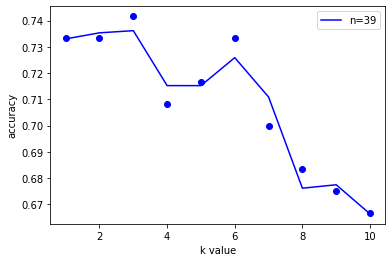

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

predictions = [[],[],[],[]]
ks = [i for i in range(1, 11)]
ksl = [[i] for i in ks]
y = [[],[],[],[]]

index = 0
for n_features in n:

  y[index] = find_accuracy(n_features, ks)[0]

  # Transform the data to include polynomial features
  poly = PolynomialFeatures(degree=7)
  X_poly = poly.fit_transform(ksl)

  # Create a LinearRegression model and fit it to the transformed data
  model = LinearRegression()
  model.fit(X_poly, y[index])

  # Make predictions using the fitted model
  predictions[index] = model.predict(X_poly)
  index += 1

# Plot the data and the predictions
colors = ['blue','orange','green','red']
for i in range(len(n)):
  plt.scatter(ksl, y[i], color=colors[i])
  plt.plot(ksl, predictions[i], color=colors[i], label='n='+str(n[i]))

  # Add x and y labels
  plt.xlabel('k value')
  plt.ylabel('accuracy')

  # Add a legend
  plt.legend(loc='best')
  plt.show()


In [ ]:
np.array(find_accuracy(n[0], [1])[1]).T.squeeze().shape
# np.array(test_labels).shape

<ipython-input-3-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)


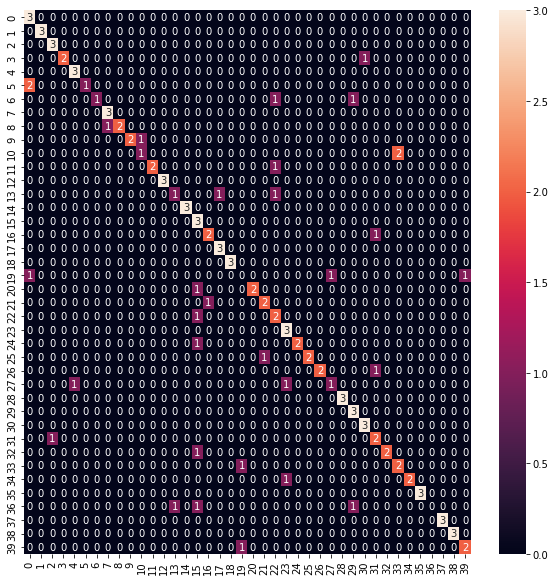

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

temp = np.array(find_accuracy(n[0], [1])[1]).T.squeeze()
cmatrix = confusion_matrix(test_labels, temp)

plt.figure(figsize=(10, 10))
sns.heatmap(cmatrix, annot=True)
plt.show()